<a href="https://colab.research.google.com/github/srbharathee/DL/blob/master/CFRGC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualize where the Convolutional Network is looking at using Grad-CAM for CIFAR10 dataset 

When solving image classification problems , it would be helpful for us to know what information from the image is being used by the network to make its preditions. Grad-CAM is a way for us to visualize the pixels in the activation channels that contribute most actively to a certain prediction . This will help us to fine tune the model in such a way that it uses all/most of the information belonging to the object being classified while making a prediction as opposed to using only small parts of the object or on the fringes or background surrounding the object being classified. This will help the model learn more about the features of a particular class .

In this exercise we will do a Grad-CAM visualization on 50 misclassified images of CIFAR10 dataset. We will use a ResNet18 pretrained model from [https://github.com/qubvel/keras-applications](https://github.com/qubvel/keras-applications)

### install the required files from qubvel keras applications project in order to get the pretrained ResNet model 

In [1]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-m22wbxag
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-m22wbxag
  Running command git submodule update --init --recursive -q
  Stored in directory: /tmp/pip-ephem-wheel-cache-9_smeh7r/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


### import necessary keras modules , numpy and matplotlib

In [2]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
#from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


### import ResNet18 and image preprocessing from the project we installed earlier 

In [0]:
import keras
from classification_models.resnet import ResNet18, preprocess_input



### get cifar10 dataset from keras datasets 

In [4]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


### plot a selection of 10 images from the train dataset 

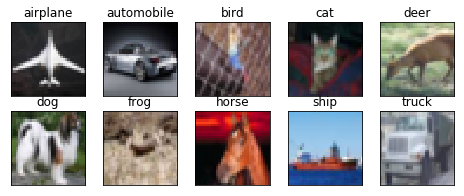

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Normalize pixel values in the images to be between 0 and 1
### convert the train and test labels to categorical data of 10 class categories 

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### preprocess the image data 

In [0]:
train_features = preprocess_input(train_features)

test_features = preprocess_input(test_features)

### we will now get the ResNet18 model weights for imagenet (Cifar is not available in this library). 
### Change the input shape to match that of CIFAR10 : 32,32,3 
### Add a 1x1 conv layer to squash the 512 channels of the pretrained model to 10 channels corresponding to 10 classes in CIFAR10
### Add GlobalAveragePooling to convert these to 1D inputs suitable for the softmax prediction layer 
### Add softmax prediction 

In [8]:
# build model
base_model = ResNet18(input_shape=(32,32,3), weights='imagenet', include_top=False)
x= Conv2D(num_classes,1,name='reducer1')(base_model.output)
x= BatchNormalization()(x)
x= Activation('relu')(x)
x = keras.layers.GlobalAveragePooling2D()(x)
output = keras.layers.Activation('softmax')(x)
model = keras.models.Model(inputs=[base_model.input], outputs=[output])



W0705 06:54:00.036911 139856733915008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0705 06:54:00.101183 139856733915008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0705 06:54:00.102250 139856733915008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0705 06:54:00.103096 139856733915008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0705 06:54:00.106116 139856

44924928/44920640 [==============================] - 1s 0us/step


### print model summary and use this information to choose the layer that we will vuse for Grad-CAM visualization. 

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

### Plot the model as png image so that we can visualize the network better 

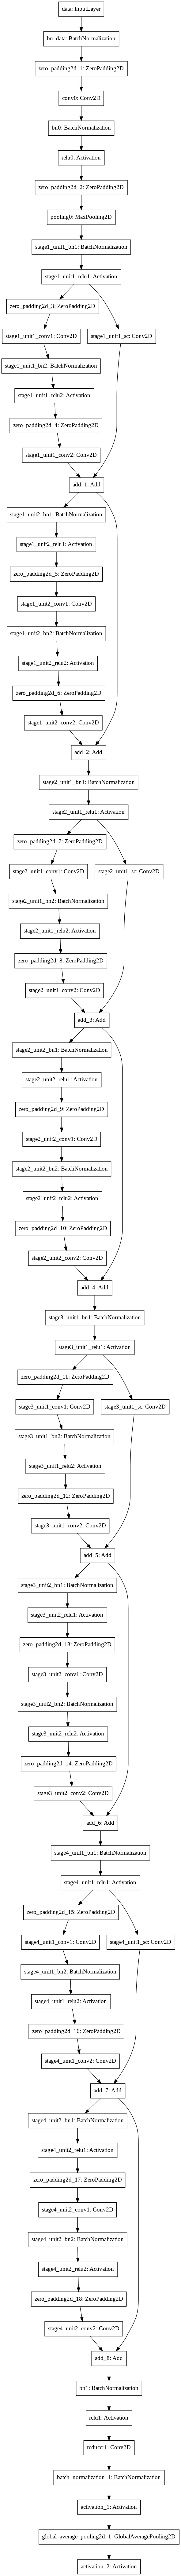

In [46]:
#plot the model as a png image and display it 

from keras.utils import plot_model
plot_model(model, to_file='model.png')

from IPython.display import Image, display
display(Image('model.png'))

### Layer named stage2_unit1_relu1 seems to be good candidate for the visualization.It has an output size of 8x8 . Layers after this are smaller (4x4 , 3x3 or 2x2)

### Compile the model using Stochastic Gradient descent optimizer with momentum of 0.9 

In [10]:
# train
from keras.optimizers import SGD
opt=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


W0705 06:54:07.100897 139856733915008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### we want to get the model with best validation accuracy for the prediction task and so we will save the best model from the various epochs in Google Drive using ModelCheckpoint callback available in Keras 
### Mount Google Drive  

In [11]:
from google.colab import drive 
drive.mount('/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


### define a Modelcheckpoint to save the best Model 

In [0]:
from keras.callbacks import ModelCheckpoint

model_save_path='/gdrive/My Drive/EIP3/session5/best_model.h5'

chkpoint_model=ModelCheckpoint(model_save_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

##Cutout Augmentation
Cutout was first presented as an effective augmentation technique in these two papers :

[Improved Regularization of Convolutional Neural Networks with Cutout](https://arxiv.org/abs/1708.04552) and [Random Erasing Data Augmentation](https://arxiv.org/abs/1708.04896)

The idea is to randomly cut away patches of information from images that a model is training on to force it to learn from more parts of the image. This would help the model learn more features about a class instead of depending on some simple assumptions using smaller areas within the image . This helps the model generalize better and make better predictions .

We will use python code for random erasing found at [https://github.com/yu4u/cutout-random-erasing](https://github.com/yu4u/cutout-random-erasing)

In [13]:
#get code for random erasing from https://github.com/yu4u/cutout-random-erasing
!wget https://raw.githubusercontent.com/yu4u/cutout-random-erasing/master/random_eraser.py


--2019-07-05 06:55:07--  https://raw.githubusercontent.com/yu4u/cutout-random-erasing/master/random_eraser.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 888 [text/plain]
Saving to: ‘random_eraser.py’

random_eraser.py    100%[===================>]     888  --.-KB/s    in 0s      

2019-07-05 06:55:08 (145 MB/s) - ‘random_eraser.py’ saved [888/888]



### Train the model for 100 epochs using a batch size of 128  . We will use a ImageDataGenerator to apply image augmentation of horizontal Flip and CutOut augmentation for the training 

In [14]:
from keras.preprocessing.image import ImageDataGenerator
from random_eraser import get_random_eraser

batch_size=128

train_datagen=ImageDataGenerator(
        #featurewise_center=True,  # set input mean to 0 over the dataset
        #samplewise_center=False,  # set each sample mean to 0
        #featurewise_std_normalization=True,  # divide inputs by std of the dataset
        #samplewise_std_normalization=False,  # divide each input by its std
        preprocessing_function=get_random_eraser(v_l=0, v_h=1),
        horizontal_flip=True
    
)

val_datagen= ImageDataGenerator(
        #featurewise_center=True,  # set input mean to 0 over the dataset
        
        #featurewise_std_normalization=True,  # divide inputs by std of the dataset
        
)


train_datagen.fit(train_features)

val_datagen.fit(test_features)

training_generator=train_datagen.flow(train_features,train_labels, batch_size=batch_size,shuffle=True,seed=42)

validation_generator=val_datagen.flow(test_features,test_labels, batch_size=batch_size,shuffle=True,seed=42)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(training_generator, epochs=100, 
                        steps_per_epoch=np.ceil(train_features.shape[0]/batch_size), 
                    validation_steps=np.ceil(test_features.shape[0]/batch_size), 
                    validation_data=validation_generator,
                                 shuffle=True,
                                 callbacks=[chkpoint_model],
                                 verbose=1)

W0705 06:55:09.960780 139856733915008 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
391/391 [==============================] - 24s 61ms/step - loss: 1.1144 - acc: 0.6402 - val_loss: 0.7899 - val_acc: 0.7427

Epoch 00001: val_acc improved from -inf to 0.74270, saving model to /gdrive/My Drive/EIP3/session5/best_model.h5
Epoch 2/100
391/391 [==============================] - 17s 44ms/step - loss: 0.7466 - acc: 0.7535 - val_loss: 0.6711 - val_acc: 0.7821

Epoch 00002: val_acc improved from 0.74270 to 0.78210, saving model to /gdrive/My Drive/EIP3/session5/best_model.h5
Epoch 3/100
391/391 [==============================] - 17s 44ms/step - loss: 0.6436 - acc: 0.7845 - val_loss: 0.6347 - val_acc: 0.7877

Epoch 00003: val_acc improved from 0.78210 to 0.78770, saving model to /gdrive/My Drive/EIP3/session5/best_model.h5
Epoch 4/100
391/391 [==============================] - 17s 44ms/step - loss: 0.5749 - acc: 0.8060 - val_loss: 0.5882 - val_acc: 0.8044

Epoch 00004: val_acc improved from 0.78770 to 0.80440, saving model to /gdrive/My Drive/EIP3/session5/best_mode

### The network was trained for 100 epochs and reached a max validation accuracy of 86.65 . We have saved the model with best validation accuracy in google drive so that we can load and use it for prediction and Grad-CAM visualization 

### Now let us define the function for Grad-CAM visualization . 
### This function named gradcam takes as input the model , the set of images , the labels for each image and the layer to be used for calculating gradients . 
### It returns a list of dictionaries containing original image , the heatmap, the titles to display during visualization 

In [0]:
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
from google.colab.patches import cv2_imshow
from IPython.core.display import display, HTML


#select test images and corresponding labels to print heatmap 
#x=np.array([test_features[41],test_features[410],test_features[222],test_features[950]])
#y=[test_labels[41],test_labels[410],test_labels[222],test_labels[950]]


def gradcam(model1,x,y,which_layer):
  #
  results=[]
  #make prediction for these 4 images 
  preds = model1.predict(x)
  for j in range(x.shape[0]):
    #get class id from the prediction values 
    class_idx = np.argmax(preds[j])

    class_output = model1.output[:, class_idx]
  
    ## choose the layer nearest to prediction that has a size of about 7x7 or 8x8 
    #in this case it is the layer being sent to the gradcam function 
    last_conv_layer = model1.get_layer(which_layer)
  
    # compute gradients and from heatmap 
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model1.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    #apply the pooled grad value to the conv layer channels 
    for i in range(64):
      
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
      
    #get the mean of the weighted values and assign to heatmap   
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    #retain only positive values (or 0) in heatmap 
    heatmap = np.maximum(heatmap, 0)
    #convert values between 0 and 1 using divide by max value 
    heatmap /= np.max(heatmap) 
    #we now have a heatmap with size equal to the output size of the layer we chose 
    
    #img is the image we are running gradcam on 
    img = x[j]
    
    #resize heatmap 8x8 to image size of 32x32 
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    #convert pixel values to be between 0 and 255 
    heatmap = np.uint8(255 * heatmap)
    #apply suitable cv2 colormap . In this case colormap_JET 
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
    # convert from BGR to RGB if we want to display using matplotlib 
    heatmap1 = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # create superimposed image if we want to print using cv2 (cv2_imshow supported in colab)
    superimposed_img = cv2.addWeighted(img, 0.5, heatmap1, 0.5, 0,dtype=5)
    
    #create a dictionary object with details of image, heatmap, its title 
    title1=str(j+1)+": "+ class_names[np.argmax(y[j])]+" predicted as "+str(class_names[class_idx])
    title2='superimposed heatmap'
    image1=img
    image2=heatmap1
    image3=superimposed_img
    imageObj={'image1':image1,'image2':image2,'image3':image3,'title1':title1,'title2':title2}
    
    #append the image dict object to results list 
    results.append(imageObj)
    #print(j)
  #return grad-cam results as a list of dictionary objects , each containing an image and its heatmap  
  return results  



### Define the function to display the Grad-CAM visualizations . 
### This function displays a set of two images with heatmap visuals per row 

In [0]:
def displayRow(images):
  # we will plot 2 images in a row 
  # cv.imshow does not work in jupyter notebooks and colab 
  # cv2_imshow patch works on colab but matplotlib gives us a little more flexibility in formatting the display
  # we will use matplotlib to print the image and its heatmap 
  fig = plt.figure(1, (13,13))

  grid = ImageGrid(fig, 111,  
                 nrows_ncols=(1,5),  
                 axes_pad=1,label_mode="1"  
                 )
  
  #horizontal spacer
  
    
  #grid[0].imshow(np.ones((32, 10)),alpha=0)
  #grid[0].axis('off')
  
  
  
  #first image
  #print(" original class is :"+class_names[np.argmax(y[j])]+" and predicted class is :"+str(class_names[class_idx]))
  grid[0].imshow(images[0]['image1'])
  grid[0].set_title(images[0]['title1'])
  grid[0].axis('off')
  
  #print the original image and on top of it place the heat map at 60% transparency 
  grid[1].imshow(images[0]['image1'],alpha=0.9)
  grid[1].imshow(images[0]['image2'],alpha=0.6)
  grid[1].set_title(images[0]['title2'])
  grid[1].axis('off')
  
  #vertical separator 
    
  grid[2].imshow(np.ones((32, 1)))
  grid[2].axis('off')
  
  #second image 
    
  #print(" original class is :"+class_names[np.argmax(y[j])]+" and predicted class is :"+str(class_names[class_idx]))
  grid[3].imshow(images[1]['image1'])
  grid[3].set_title(images[1]['title1'])
  grid[3].axis('off')
  
  #print the original image and on top of it place the heat map at 60% transparency 
  grid[4].imshow(images[1]['image1'],alpha=0.9)
  grid[4].imshow(images[1]['image2'],alpha=0.6)
  grid[4].set_title(images[1]['title2'])
  grid[4].axis('off')
  
  
  
  plt.show()
  display(HTML("<hr size='5' color='black' width='100%' align='center' />"))

### Now that we have done the preparatory work for the visualization , let us load the model with best validation accuracy from earlier training 

In [0]:
from keras.models import load_model
model=load_model(model_save_path)

### Make predictions using the model and collect all the images that were classified wrongly 

In [0]:
pred=model.predict(test_features)
pred2=np.argmax(pred,axis=1)
wrong_set=[]
correct_set=[]
wrong_labels=[]
true_labels=[]
wrong_indices=[]
for i in range(test_features.shape[0]):
  
  if (pred2[i]==np.argmax(test_labels[i])):
    
    correct_set.append(test_features[i])
  else:
    wrong_indices.append(i)
    wrong_labels.append(class_names[pred2[i]])
    true_labels.append(class_names[np.argmax(test_labels[i])])
    wrong_set.append(test_features[i])


### Now take the first 50 images and the corresponding labels to create the data for Grad-CAM visualization 

In [0]:
#take the first 50 images and labels from misclassified set 
w_list=wrong_indices[:50]
x=[]
y=[]
for i in range(len(w_list)):
  x.append(test_features[w_list[i]])
  y.append(test_labels[w_list[i]])
  
#convert the image list to numpy array   
x=np.array(x)

### Obtain results from the gradcam function 

In [0]:
results=gradcam(model,x,y,'stage2_unit1_relu1') # we choose this layer as the layer nearest to prediction and having a size of 8x8 


### display the results from gradcam function with images and corresponding heatmap visuals

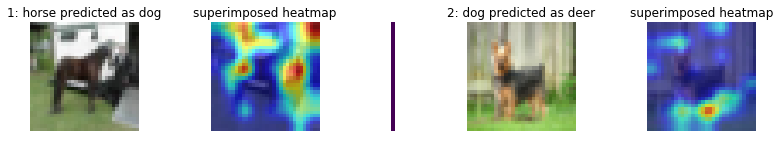

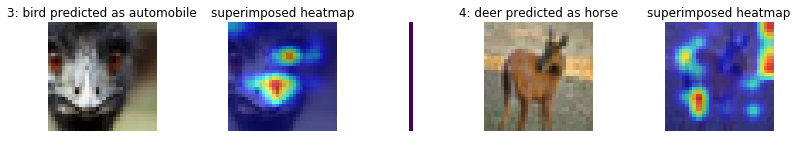

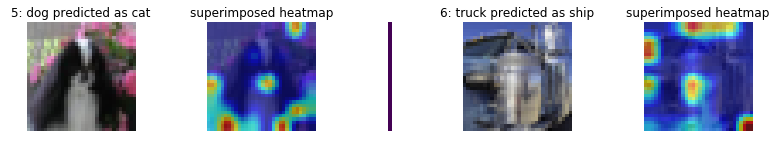

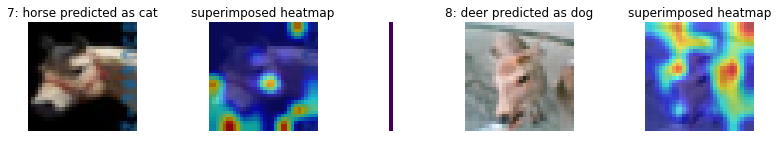

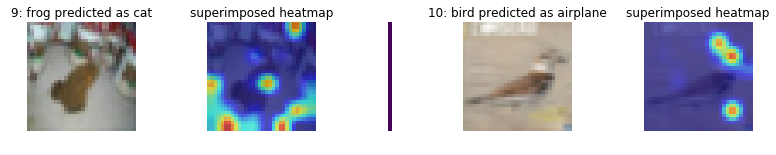

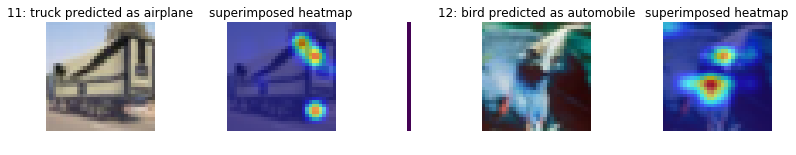

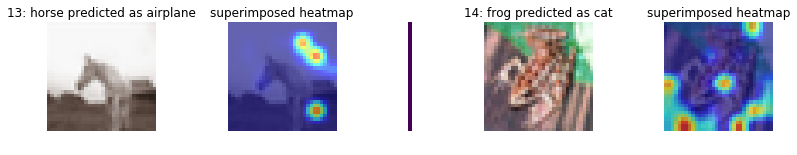

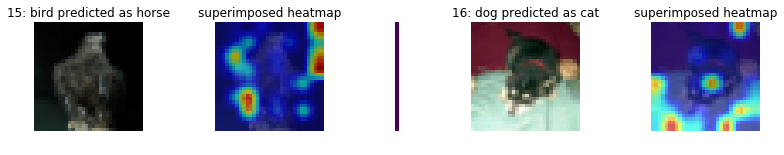

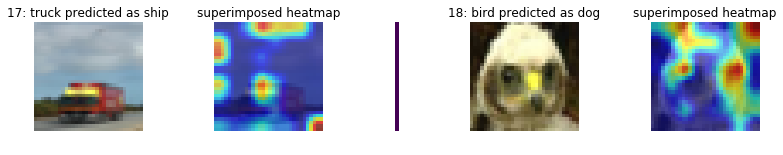

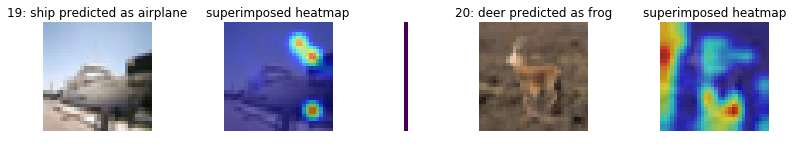

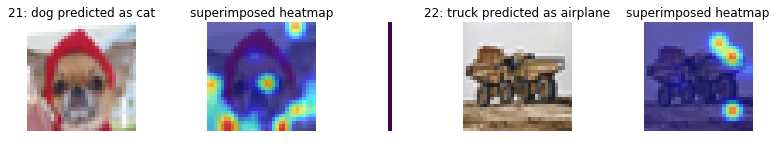

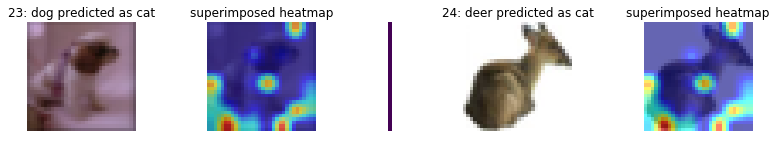

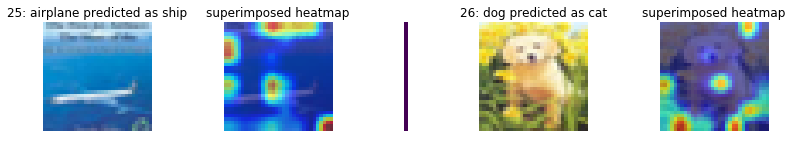

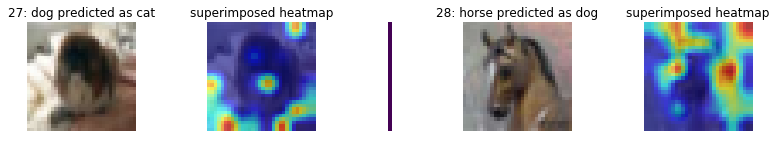

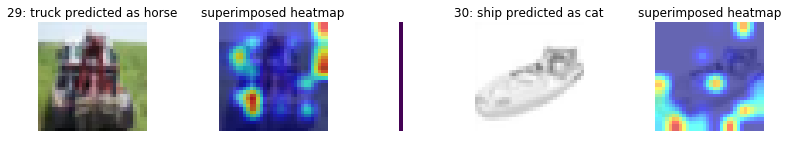

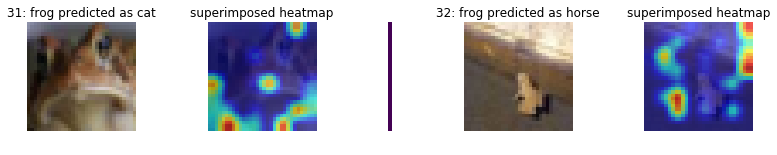

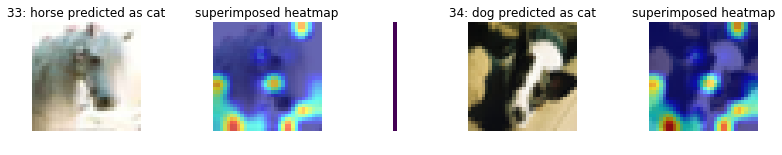

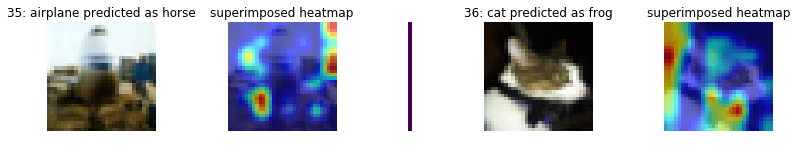

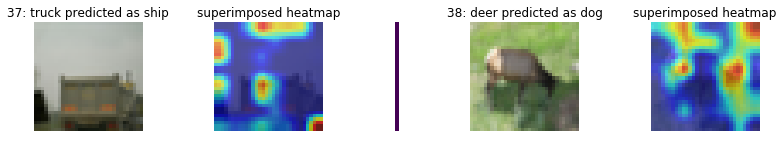

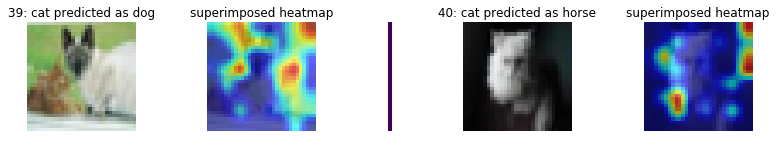

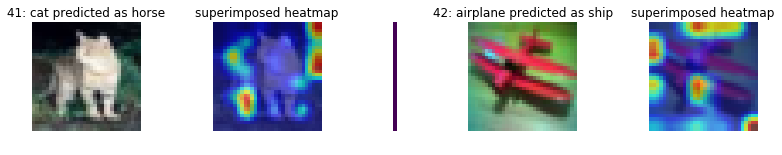

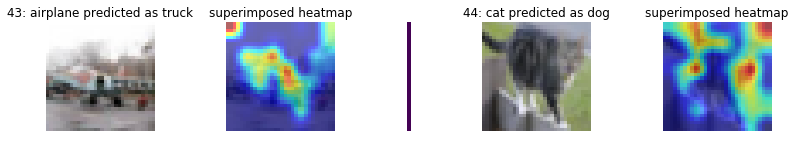

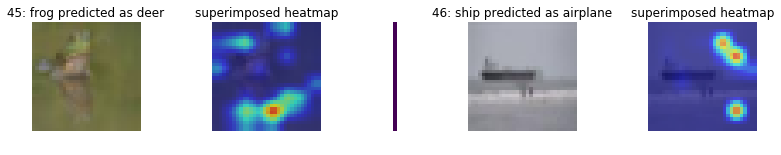

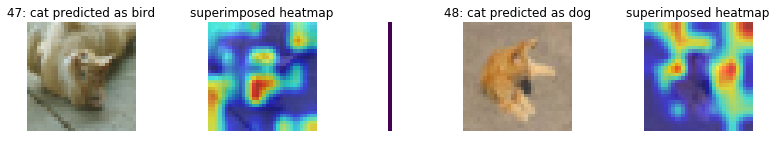

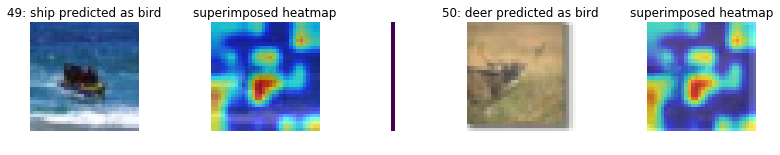

In [43]:
display(HTML("<h2 align='center'>First 50 misclassified images with Grad-CAM heatmap </h2><hr size='5' color='black' width='100%' align='center' />"))
for i in range(0,len(results),2):
  images=[]
  images.append(results[i])
  images.append(results[i+1])
  displayRow(images)

### We used a pre-trained a ResNet18 model with ImageNet weights to learn the CIFAR10 dataset . We made predictions on the dataset and collected 50 misclassified images. We then used Grad-CAM to visualize the heatmap for each of these 50 images and displayed the images together with the heatmaps for a better undertsanding of where the model is looking at or which pixels in a chosen layer are most actively contributing when making predictions for a certain class 